In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sun Feb  1 16:28:20 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00000000

In [2]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [4]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [5]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [ ]:
from ad_afqmc import linalg_utils
from jax import lax
import jax
from jax import numpy as jnp

@jit
def uwalker_norm(
    walker_up: jax.Array,
    walker_dn: jax.Array,
) -> float:
    norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
        ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
    return jnp.real(norm)


@jit
def qr_walker_uhf(walker_up, walker_dn):
    nocc_up = walker_up.shape[1]
    nocc_dn = walker_dn.shape[1]
    q_up, r_up = jnp.linalg.qr(walker_up)
    q_dn, r_dn = jnp.linalg.qr(walker_dn)
    norm_up = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_up[:,:nocc_up].conj().T @ r_up[:,:nocc_up])
            )
        )
    norm_dn = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_dn[:,:nocc_dn].conj().T @ r_dn[:,:nocc_dn])
            )
        )
    return (q_up, q_dn), norm_up * norm_dn

def qr_walkers_uhf(walkers):
    (walkers_up, walkers_dn), norms \
        = vmap(qr_walker_uhf, in_axes=(0, 0))(walkers[0], walkers[1])
    return (walkers_up, walkers_dn), norms

# @jit
# def stochastic_reconfiguration_uhf(walkers, weights, zeta):
#     nwalkers = walkers[0].shape[0]
#     cumulative_weights = jnp.cumsum(jnp.abs(weights))
#     total_weight = cumulative_weights[-1]
#     average_weight = total_weight / nwalkers
#     weights = jnp.ones(nwalkers, dtype=jnp.complex128) * average_weight
#     z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
#     indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
#     walkers[0] = walkers[0][indices]
#     walkers[1] = walkers[1][indices]
#     return walkers, weights

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    
    # prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    # weights = jnp.real(norms[0] * norms[1])
    # nwalker = int(prop_data["weights"].shape[0])
    # prop_data["weights"] *= weights
    # prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    # prop_data["weights"] *= prop_data["overlaps"]
    # prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data


@partial(jit, static_argnums=(3))
def fp_step(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_qr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    (prop_data["walkers"][0], prop_data["walkers"][1]), norms \
        = qr_walkers_uhf(prop_data["walkers"])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= norms 
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_qr2(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    return prop_data, fields

# @partial(jit, static_argnums=(3))
# def fp_step_sr(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
#     prop_data["weights"] *= prop_data["overlaps"]
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     zeta = random.uniform(subkey)
#     prop_data["walkers"], prop_data["weights"] \
#         = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
#     prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
#     prop_data["weights"] /= prop_data["overlaps"]
#     # prop_data = prop.stochastic_reconfiguration_local(prop_data)
#     return prop_data, fields

@partial(jit, static_argnums=(2, 3, 5))
def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_qr2(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr2(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)

# @partial(jit, static_argnums=(2, 3, 5))
# def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
#     """free propagation for a block of (n_prop_steps, n_walkers)."""
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     fields = random.normal(
#         subkey,
#         shape=(
#             sampler.n_prop_steps,
#             prop.n_walkers,
#             ham_data["chol"].shape[0],
#         ),
#     )
#     _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
#     prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

#     prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
#     energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
#     energy_samples = jnp.where(
#         jnp.abs(energy_samples - prop_data["e_estimate"]
#                 ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
#                 energy_samples)
    
#     block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    
#     block_energy = jnp.sum(
#         energy_samples * prop_data["weights"] * prop_data["overlaps"] 
#         ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )

#     # prop_data = prop.stochastic_reconfiguration_local(prop_data)
#     # prop_data["key"], subkey = random.split(prop_data["key"])
#     # zeta = random.uniform(subkey)
#     # prop_data["walkers"], prop_data["weights"] \
#     #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

#     return prop_data, (block_energy, block_weight)


# @partial(jit, static_argnums=(2, 3, 5))
# def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
#     """free propagation for a block of (n_prop_steps, n_walkers)."""
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     fields = random.normal(
#         subkey,
#         shape=(
#             sampler.n_prop_steps,
#             prop.n_walkers,
#             ham_data["chol"].shape[0],
#         ),
#     )
#     _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
#     prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

#     prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
#     block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
#     energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
#     energy_samples = jnp.where(
#         jnp.abs(energy_samples - prop_data["e_estimate"]
#                 ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
#                 energy_samples)
#     block_energy = jnp.sum(
#         energy_samples * prop_data["overlaps"] * prop_data["weights"]
#         ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
#     return prop_data, (block_energy, block_weight)

# @partial(jit, static_argnums=(2, 3, 5))
# def fp_block_srabs(prop_data, ham_data, prop, trial, wave_data, sampler):
#     """free propagation for a block of (n_prop_steps, n_walkers)."""
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     fields = random.normal(
#         subkey,
#         shape=(
#             sampler.n_prop_steps,
#             prop.n_walkers,
#             ham_data["chol"].shape[0],
#         ),
#     )
#     _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
#     prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

#     prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
#     energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
#     block_energy = jnp.sum(
#         energy_samples * prop_data["overlaps"] * prop_data["weights"]
#         ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
#     block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])

#     # prop_data["key"], subkey = random.split(prop_data["key"])
#     # zeta = random.uniform(subkey)
#     # prop_data["walkers"], prop_data["weights"] \
#     #     = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
#     # # prop_data = prop.stochastic_reconfiguration_local(prop_data)
#     return prop_data, (block_energy, block_weight)

In [17]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844824


In [18]:
nstep = 30
fp_e = np.zeros(nstep+1,dtype=np.complex128)
fp_w = np.zeros(nstep+1,dtype=np.complex128)
fp_e[0] = prop_data["e_estimate"]
fp_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_e[n+1] = blk_e
    fp_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (nan+nanj) (nan+nanj)
2 (nan+nanj) (nan+nanj)
3 (nan+nanj) (nan+nanj)
4 (nan+nanj) (nan+nanj)
5 (nan+nanj) (nan+nanj)
6 (nan+nanj) (nan+nanj)
7 (nan+nanj) (nan+nanj)
8 (nan+nanj) (nan+nanj)
9 (nan+nanj) (nan+nanj)
10 (nan+nanj) (nan+nanj)
11 (nan+nanj) (nan+nanj)
12 (nan+nanj) (nan+nanj)
13 (nan+nanj) (nan+nanj)
14 (nan+nanj) (nan+nanj)
15 (nan+nanj) (nan+nanj)
16 (nan+nanj) (nan+nanj)
17 (nan+nanj) (nan+nanj)
18 (nan+nanj) (nan+nanj)
19 (nan+nanj) (nan+nanj)
20 (nan+nanj) (nan+nanj)
21 (nan+nanj) (nan+nanj)
22 (nan+nanj) (nan+nanj)
23 (nan+nanj) (nan+nanj)
24 (nan+nanj) (nan+nanj)
25 (nan+nanj) (nan+nanj)
26 (nan+nanj) (nan+nanj)
27 (nan+nanj) (nan+nanj)
28 (nan+nanj) (nan+nanj)
29 (nan+nanj) (nan+nanj)
30 (nan+nanj) (nan+nanj)


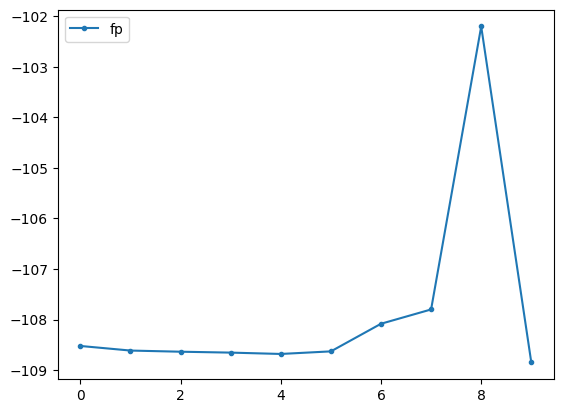

In [139]:
from matplotlib import pyplot as plt

plt.plot(fp_e.real,'.-',label='fp',color='C0')

plt.legend()
plt.show()

In [14]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 30
fp_qr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_e[0] = prop_data["e_estimate"]
fp_qr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_qr_e[n+1] = blk_e
    fp_qr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.53345239361374-0.0025277960603534277j) (13.451817530406522+0.10278537765210567j)
2 (-108.49291587823015+0.02805070139558483j) (4.219811466446599-0.04078869875217343j)
3 (-108.696575227484-0.016233636903921555j) (3.5442876355236312+0.07106921560986167j)
4 (-108.72964775902089-0.03801578623883602j) (2.9724275026588645+0.0455769420987516j)
5 (-108.55094804764467+0.04627181283800618j) (-4.168193808974839-1.4237974614315525j)
6 (-108.5033301556806-0.11684149614475886j) (0.8923617023807937-1.028420352403128j)
7 (-108.70826509465266-0.15423842797479734j) (1.598626393869102+0.03500314585246256j)
8 (-108.50117941372989+0.010562016147909654j) (4.667868946164677-1.1858151163585908j)
9 (-108.71772434475669-0.13486737403715382j) (0.48762408337670893-1.8927933441123168j)
10 (-108.53759910505356-0.060390355279972004j) (-3.799967735899945-0.4470233567023368j)
11 (-108.50525914916842-0.06508611588463109j) (2.729930175601862-2.8197236962273657j)
12 (-108.44214776702441-0.016403028516949157j) (-4

In [10]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 30
fp_qr2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_qr2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_qr2_e[0] = prop_data["e_estimate"]
fp_qr2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_qr2(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_qr2_e[n+1] = blk_e
    fp_qr2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61427717952677+0.001029966591097285j) (111.47250144837668-0.27378810210323967j)
2 (-108.6371780809357+0.00011565389425872614j) (427.74077040562895-2.123853672855094j)
3 (-108.65496283385458+0.008071383210537644j) (170.9272272447969+1.1723059845358335j)
4 (-108.68154066361728+0.007933608482427973j) (191.09851939726627+1.6820447049475806j)
5 (-108.63124045922211-0.01001662203238693j) (-155.38127084061412+4.634075179336078j)
6 (-108.63076751229771-0.006071800068279185j) (325.367114651992-10.774442783389766j)
7 (-108.6399973550794-0.018687619955610243j) (413.90840243130134-25.635951054223483j)
8 (-108.62276562845763-0.011868806159319458j) (327.92684978036266-14.626528639033134j)
9 (-108.64695091099131+0.00415916290239882j) (949.1662380836233-34.61807864620556j)
10 (-108.62803681387919-0.00683914173841012j) (-132.64604561960925+3.929841467801404j)
11 (-108.65919159980204-0.01150341695956868j) (145.93682003007993-13.49909360234888j)
12 (-108.6654283041565+0.0022874691909460015j) (-83

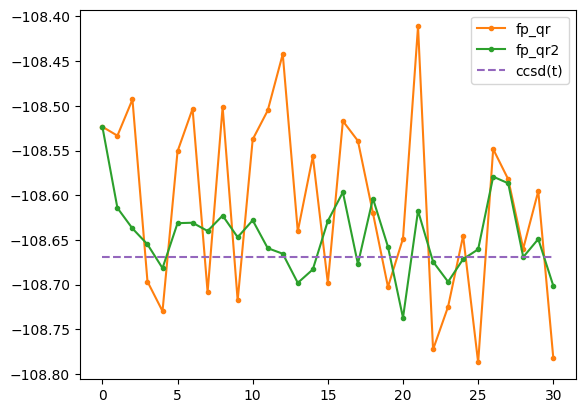

In [15]:
from matplotlib import pyplot as plt

# plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C1')
plt.plot(fp_qr2_e.real,'.-',label='fp_qr2',color='C2')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()